Код, позволяющий подключиться ноутбуку к вашему гугл диску

In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


Импорты библиотек

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import tensorflow as tf
from PIL import Image
import scipy
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, LSTM, Concatenate
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Reshape
import re

Вспомогательные функции, потребуются для работы с картинками

In [3]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_crop_padded(im, w, h, pad):
    list_patches = []
    
    imgwidth = im.shape[0] - pad
    imgheight = im.shape[1] - pad
    
    is_2d = len(im.shape) < 3
    for i in range(pad,imgheight,h):
        for j in range(pad,imgwidth,w):
            if is_2d:
                im_patch = im[j-pad:j+w+pad, i-pad:i+h+pad]
            else:
                im_patch = im[j-pad:j+w+pad, i-pad:i+h+pad, :]
            list_patches.append(im_patch)
    return list_patches

def deflatten(img_flat, patch_size):
    img = []
    for i in range(len(img_flat)):
        img.append(img_flat[i].reshape((patch_size,patch_size)))
    return img


# Function to ransform patches into a complete black and white image
def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def img_crop_output(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h].flatten() # Here we add the flatten function
            else:
                im_patch = im[j:j+w, i:i+h, :].flatten() # Here we add the flatten function
            list_patches.append(im_patch)
    return list_patches


def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

foreground_threshold = 0.25

def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


Начало работы скрипта: загружаем картинки и маски

In [6]:
# image
image_dir = "/content/MyDrive/MyDrive/data/training/images/"
files = os.listdir(image_dir)
n = 100
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

pad = 4
print("Loading " + str(n) + " images_padded")
imgs_padded = [np.pad(load_image(image_dir + files[i]), ((pad,pad),(pad,pad),(0,0)), 'constant') for i in range(n)]
print(files[0])

# groundtruth
gt_dir = "/content/MyDrive/MyDrive/data/training/groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

# testing
testimage_dir = "/content/MyDrive/MyDrive/data/testing_set_images/test/"
files2 = os.listdir(testimage_dir)
k = 5
print("Loading " + str(k) + " images")
test_imgs = [load_image(testimage_dir + files2[i]) for i in range(k)]
print(files2[0])
pad = 4
print("Loading " + str(k) + " images_padded")
testing_padded = [np.pad(load_image(testimage_dir + files2[i]), ((pad,pad),(pad,pad),(0,0)), 'constant') for i in range(k)]
print(files2[0])

Loading 100 images
satImage_095.png
Loading 100 images_padded
satImage_095.png
Loading 100 images
satImage_095.png
Loading 5 images
test_3.png
Loading 5 images_padded
test_3.png


Пример загруженной картинки и ее маски

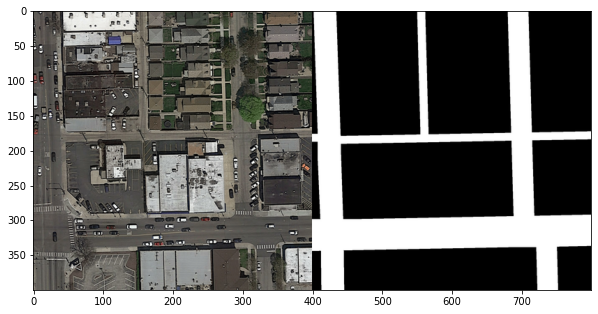

In [ ]:
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

Преобразование картинки в массив из "патчей", 16х16 пикселей

In [ ]:
patch_size = 16
n = 100
img_patches = [img_crop_padded(imgs_padded[i], patch_size, patch_size, pad) for i in range(n)]
gt_patches = [img_crop_output(gt_imgs[i], patch_size, patch_size) for i in range(n)]
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

print('Size patch image', img_patches.shape)
print('Size patch groundtruth', gt_patches.shape)

X_train = img_patches
Y_train = gt_patches

Первая ветвь нейронки

In [12]:
model_cnn = Sequential()
model_cnn.add(Convolution2D(32, 3, 3, activation='relu', padding='same', input_shape=(24, 24, 3)))
model_cnn.add(Convolution2D(32, 3, 3, activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_cnn.add(Dropout(0.25)) 

model_cnn.add(Convolution2D(64, 3, 3, activation='relu', padding='same'))
model_cnn.add(Convolution2D(64, 3, 3, activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_cnn.add(Dropout(0.25))

model_cnn.add(Convolution2D(128, 3, 3, activation='relu', padding='same'))
model_cnn.add(Convolution2D(128, 3, 3, activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())
model_cnn.add(Dense(1024, activation='relu'))
model_cnn.add(Dropout(0.5))

Соединяем две ветви нейронки в одну, получаем результирующую модель нейронной сети

In [13]:
model_cnn2 = Sequential()
model_cnn2.add(Convolution2D(32, 3, 3, activation='relu', padding='same', input_shape=(24, 24, 3)))
model_cnn2.add(Convolution2D(32, 3, 3, activation='relu', padding='same'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_cnn2.add(Dropout(0.25)) 

model_cnn2.add(Convolution2D(64, 3, 3, activation='relu', padding='same'))
model_cnn2.add(Convolution2D(64, 3, 3, activation='relu', padding='same'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_cnn2.add(Dropout(0.25))

model_cnn2.add(Flatten())
model_cnn2.add(Dense(1024, activation='relu'))
model_cnn2.add(Dropout(0.5))

Настройки компиляции модели. Запускаем тренировку на тренировчных данных

In [ ]:
del model_final

In [ ]:
from keras.layers.merge import concatenate, average
from keras.models import Model, Sequential
from keras.layers import Dense, Input

merged = average([model_cnn2.output,model_cnn.output])
output = Dense(256, activation='sigmoid')(merged)
model_final = Model([model_cnn2.inputs, model_cnn.inputs], output)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_final.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
model_final.fit([X_train, X_train], y=Y_train, batch_size=32, epochs=10, verbose=2, validation_split=0.1, shuffle=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/600
1758/1758 - 15s - loss: 0.1009 - accuracy: 0.0051 - val_loss: 0.0864 - val_accuracy: 0.0018
Epoch 2/600
1758/1758 - 13s - loss: 0.0885 - accuracy: 0.0037 - val_loss: 0.0828 - val_accuracy: 0.0030
Epoch 3/600
1758/1758 - 13s - loss: 0.0868 - accuracy: 0.0045 - val_loss: 0.0822 - val_accuracy: 0.0029
Epoch 4/600
1758/1758 - 13s - loss: 0.0852 - accuracy: 0.0050 - val_loss: 0.0814 - val_accuracy: 0.0026
Epoch 5/600
1758/1758 - 13s - loss: 0.0843 - accuracy: 0.0046 - val_loss: 0.0814 - val_accuracy: 0.0034
Epoch 6/600
1758/1758 - 13s - loss: 0.0840 - accuracy: 0.0049 - val_loss: 0.0821 - val_accuracy: 0.0037
Epoch 7/600
1758/1758 - 13s - loss: 0.0833 - accuracy: 0.0047 - val_loss: 0.0809 - val_accuracy: 0.0034
Epoch 8/600
1758/1758 - 13s - loss: 0.0828 - accuracy: 0.0055 - val_loss: 0.0796 - val_accuracy: 0.0037
Epoch 9/600
1758/1758 - 13s - loss: 0.0826 - accuracy: 0.0053 - val_loss: 0.0809 - val_accuracy: 0.0046
Epoch 10/600
1758/1758 - 13s - loss: 0.0825 - accuracy: 0.0060 -

Понравилось? Сохраняем веса в корень гугл диска

In [ ]:
model_final.save("/content/MyDrive/MyDrive/modelRoads666")

INFO:tensorflow:Assets written to: /content/MyDrive/MyDrive/modelRoads666/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Загрузка готовой модели

In [4]:
from keras.models import load_model
#del model_final
model_final = load_model("/content/MyDrive/MyDrive/modelRoads666")

Ну и соответственно просмотр изображения с маской

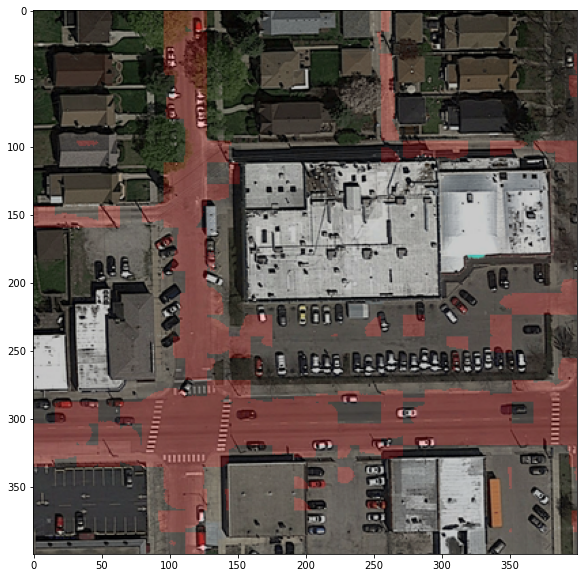

In [7]:
img_idx = 4 #Выберите число от 0 до 49, чтобы посмотреть предсказанные маски на других тестовых картинках
X_test = np.asarray(img_crop_padded(imgs_padded[img_idx], 16, 16, pad))
prediction = model_final.predict([X_test,X_test], batch_size=32)
pred = np.array(prediction)
predict_binary = np.where(prediction > 0.5, 1, 0)
im_test = deflatten(predict_binary, 16)
im_non_flat = np.asarray(im_test)
w = imgs[img_idx].shape[0]
h = imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, 16, 16, im_non_flat)
new_img = make_img_overlay(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(new_img)

In [ ]:
import re
import argparse

from PIL import Image
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os


def html_url_parser(url, save_dir, show=False, wait=False):
    """
    HTML parser to download images from URL.
    Params:\n
    `url` - Image url\n
    `save_dir` - Directory to save extracted images\n
    `show` - Show downloaded image\n
    `wait` - Press key to continue executing
    """

    website = urlopen(url)
    html = website.read()

    soup = BeautifulSoup(html, "html5lib")

    for image_id, link in enumerate(soup.find_all('a', href=True)):
        if (image_id == 0):
            continue

        img_url = link['href']

        try:
            if os.path.isfile(save_dir + "img-%d.png" % image_id) == False:
                print("[INFO] Downloading image from URL:", link['href'])
                image = Image.open(urlopen(img_url))
                image.save(save_dir + "img-%d.png" % image_id, "PNG")
                if (show):
                    image.show()
            else:
                print('skipped')
        except KeyboardInterrupt:
            print("[EXCEPTION] Pressed 'Ctrl+C'")
            break
        except Exception as image_exception:
            print("[EXCEPTION]", image_exception)
            continue

        if (wait):
            key = input("[INFO] Press any key to continue ('q' to exit)... ")
            if (key.lower() == 'q'):
                break


# ///////////////////////////////////////////////////
#                   Main method
# ///////////////////////////////////////////////////
if __name__ == "__main__":
    URL_TRAIN_IMG = "https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/index.html"
    URL_TRAIN_GT = "https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/map/index.html"

    URL_TEST_IMG = "https://www.cs.toronto.edu/~vmnih/data/mass_roads/valid/sat/index.html"
    URL_TEST_GT = "https://www.cs.toronto.edu/~vmnih/data/mass_roads/valid/map/index.html"

    html_url_parser(url=URL_TRAIN_IMG, save_dir="/content/MyDrive/MyDrive/training/input/")
    html_url_parser(url=URL_TRAIN_GT, save_dir="/content/MyDrive/MyDrive/training/output/")

    html_url_parser(url=URL_TEST_IMG, save_dir="/content/MyDrive/MyDrive/testing/input/")
    html_url_parser(url=URL_TEST_GT, save_dir="/content/MyDrive/MyDrive/testing/output/")

    print("[INFO] All done!")

[INFO] Downloading image from URL: http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/10078675_15.tiff
[INFO] Downloading image from URL: http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/10078690_15.tiff
[INFO] Downloading image from URL: http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/10078705_15.tiff
[INFO] Downloading image from URL: http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/10078720_15.tiff
[INFO] Downloading image from URL: http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/10078735_15.tiff
[INFO] Downloading image from URL: http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/10078750_15.tiff
[INFO] Downloading image from URL: http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/10228660_15.tiff
[INFO] Downloading image from URL: http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/10228675_15.tiff
[INFO] Downloading image from URL: http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/10228705_15.tiff
[

In [8]:
# image
image_dir = "/content/MyDrive/MyDrive/training/input/"
files = os.listdir(image_dir)
n = 100
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

pad = 4
print("Loading " + str(n) + " images_padded")
imgs_padded = [np.pad(load_image(image_dir + files[i]), ((pad,pad),(pad,pad),(0,0)), 'constant') for i in range(n)]
print(files[0])

# groundtruth
gt_dir = "/content/MyDrive/MyDrive/training/output/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
img-108.png
Loading 100 images_padded
img-108.png
Loading 100 images
img-108.png


In [9]:
patch_size = 16
n = 100
img_patches = [img_crop_padded(imgs_padded[i], patch_size, patch_size, pad) for i in range(n)]
gt_patches = [img_crop_output(gt_imgs[i], patch_size, patch_size) for i in range(n)]
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

print('Size patch image', img_patches.shape)
print('Size patch groundtruth', gt_patches.shape)

X_train = img_patches
Y_train = gt_patches

Size patch image (883600,)
Size patch groundtruth (883600,)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
del model_final

In [ ]:
from keras.layers.merge import concatenate, average
from keras.models import Model, Sequential
from keras.layers import Dense, Input

merged = average([model_cnn2.output,model_cnn.output])
output = Dense(256, activation='sigmoid')(merged)
model_final = Model([model_cnn2.inputs, model_cnn.inputs], output)
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model_final.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

model_final.fit([X_train, X_train], y=Y_train, batch_size=32, epochs=2, verbose=2, validation_split=0.1, shuffle=True)

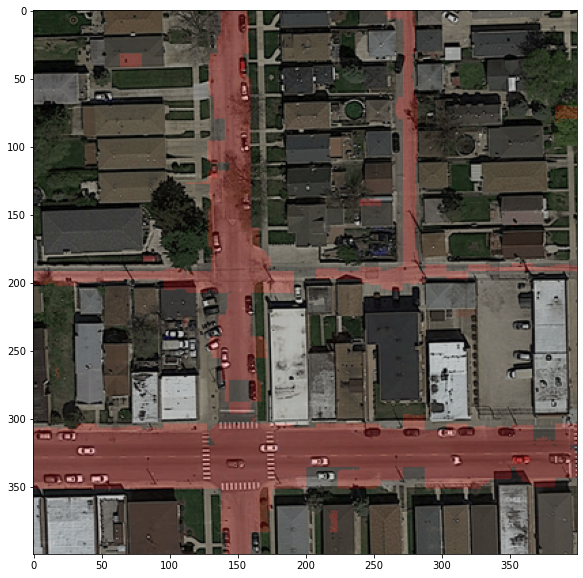

In [ ]:
img_idx = 22 #Выберите число от 1 до 50, чтобы посмотреть предсказанные маски на других тестовых картинках
X_test = np.asarray(img_crop_padded(imgs_padded[img_idx], patch_size, patch_size, pad))
prediction = model_final.predict([X_test,X_test], batch_size=32)
pred = np.array(prediction)
predict_binary = np.where(prediction > 0.5, 1, 0)
im_test = deflatten(predict_binary, patch_size)
im_non_flat = np.asarray(im_test)
w = imgs[img_idx].shape[0]
h = imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, im_non_flat)
new_img = make_img_overlay(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(new_img)